In [1]:
import numpy as np
from scipy.optimize import minimize

In [12]:
def objective(params, X, m, gamma1, gamma2):
    n, l = X.shape
    A = params[:n**2].reshape((n, n))
    S = params[n**2:].reshape((n, l))
    t = np.sum(S, axis=0)
    return np.linalg.norm(X - np.dot(A, S))**2 + np.linalg.norm(m - t)**2

def update_A(S, X, gamma2):
    n, l = X.shape
    E = np.eye(n) - 1/n
    A = np.dot(X, S.T) + gamma2 * E
    SS = np.dot(S, S.T) + gamma2 * np.eye(l)
    A = np.dot(A, np.linalg.inv(SS))
    np.fill_diagonal(A, 1)
    return A.ravel()

def update_S(A, X):
    return np.linalg.lstsq(A, X, rcond=None)[0].ravel()

def minimize_function(X, m, gamma1, gamma2):

    # initialize A as identity matrix and S as X
    n, l = X.shape
    A_init = np.eye(n)
    S_init = X.copy()

    # set bounds for A and S separately
    A_bounds = [(1, 1) if i == j else (gamma1, gamma2) for i in range(n) for j in range(n)]
    S_bounds = [(-np.inf, np.inf)] * (n * l)
    bounds = A_bounds + S_bounds

    # alternating optimization
    params = np.concatenate([A_init.ravel(), S_init.ravel()])
    res = minimize(objective, params, args=(X, m, gamma1, gamma2), method='L-BFGS-B', bounds=bounds)

    # extract the optimized A and S
    A_opt = res.x[:n**2].reshape((n, n))
    S_opt = res.x[n**2:].reshape((n, l))
    
    return A_opt, S_opt


In [24]:
A = np.array([[1, 0.02, 0.22],
             [0.1, 1, 0.02],
             [0.1, 0.1, 1]])

In [25]:
S = np.random.random((3, 10))
X = A @ S

In [26]:
m = S[0]+S[1]+S[2]

In [27]:
gamma1 = 0
gamma2 = 1
A_opt, S_opt = minimize_function(X, m, gamma1, gamma2)
l1 = np.linalg.norm(X - np.dot(A_opt, S_opt))
l2 = np.linalg.norm(m - (S_opt[0]+S_opt[1]+S_opt[2]))
np.round(A_opt, 2),l1, l2, l1+l2

(array([[1.  , 0.07, 0.12],
        [0.09, 1.  , 0.11],
        [0.11, 0.05, 1.  ]]),
 8.935877837194792e-05,
 1.500724578817134e-05,
 0.00010436602416011925)

In [28]:
np.linalg.norm(A-A_opt), np.linalg.norm(S-S_opt)

(0.1465734366855085, 0.18654120504268856)

In [69]:
import librosa as lb
import soundfile as sf
from matplotlib import pyplot as plt
import os
import museval

In [109]:
#os.listdir('/home/rajesh/Desktop/Datasets/musdb18hq_bleeded/test/')

In [110]:
bleed_path = '/home/rajesh/Desktop/Datasets/musdb18hq_bleeded/test/Sambasevam Shanmugam - Kaathaadi/'
bvocals, fs = lb.load(bleed_path+'vocals.wav')
bbass, fs = lb.load(bleed_path+'bass.wav')
bdrums, fs = lb.load(bleed_path+'drums.wav')
bother, fs = lb.load(bleed_path+'other.wav')

clean_path = '/home/rajesh/Desktop/Datasets/musdb18hq/test/Sambasevam Shanmugam - Kaathaadi/'
vocals, fs = lb.load(clean_path+'vocals.wav')
bass, fs = lb.load(clean_path+'bass.wav')
drums, fs = lb.load(clean_path+'drums.wav')
other, fs = lb.load(clean_path+'other.wav')

mixture, fs = lb.load(clean_path+'mixture.wav')

In [111]:
if len(bbass) > len(bass):
    n_ = len(bass)
else:
    n_ = len(bbass)
    
if n_ > len(mixture):
    n_ = len(mixture)
    
vocals = vocals[:n_]
bass = bass[:n_]
drums = drums[:n_]
other = other[:n_]

bvocals = bvocals[:n_]
bbass = bbass[:n_]
bdrums = bdrums[:n_]
bother = bother[:n_]

m = mixture[:n_]

In [112]:
1 *fs

22050

In [113]:
X = np.array([bvocals, bbass, bdrums, bother])
S = np.array([vocals, bass, drums, other])

X.shape, S.shape, m.shape

((4, 7009232), (4, 7009232), (7009232,))

In [114]:
X = X[:, :220500] #10 seconds
S = S[:, :220500]
m = m[:220500]

In [115]:
X.shape, S.shape, m.shape

((4, 220500), (4, 220500), (220500,))

In [ ]:
block = 25
gamma1 = 0
gamma2 = 1
S_pred, A_pred = [], []
for i in range(0, X.shape[1], block):
    A_opt, S_opt = minimize_function(X[:, i:i+block], m[i:i+block], gamma1, gamma2)
    l1 = np.linalg.norm(X[:, i:i+block] - np.dot(A_opt, S_opt))
    l2 = np.linalg.norm(m[i:i+block] - (S_opt[0]+S_opt[1]+S_opt[2]+S_opt[3]))
    print('Iteration: ', i+1, 'ERROR:', np.round(l1, 4), np.round(l2, 4), np.round(l1+l2, 4), sep='\t')
    print('DISTANCE:', np.round(np.linalg.norm(m[i:i+block] - (S_opt[0]+S_opt[1]+S_opt[2]+S_opt[3])), 4), sep='\t')
    S_pred.append(S_opt)
    A_pred.append(A_opt)

Iteration: 	1	ERROR:	0.0001	0.0	0.0001
DISTANCE:	0.0
Iteration: 	26	ERROR:	0.0001	0.0	0.0001
DISTANCE:	0.0
Iteration: 	51	ERROR:	0.0	0.0	0.0001
DISTANCE:	0.0
Iteration: 	76	ERROR:	0.0001	0.0001	0.0002
DISTANCE:	0.0001
Iteration: 	101	ERROR:	0.0	0.0	0.0
DISTANCE:	0.0
Iteration: 	126	ERROR:	0.0001	0.0	0.0001
DISTANCE:	0.0
Iteration: 	151	ERROR:	0.0001	0.0	0.0001
DISTANCE:	0.0
Iteration: 	176	ERROR:	0.0	0.0	0.0001
DISTANCE:	0.0
Iteration: 	201	ERROR:	0.0001	0.0	0.0001
DISTANCE:	0.0
Iteration: 	226	ERROR:	0.0	0.0	0.0001
DISTANCE:	0.0
Iteration: 	251	ERROR:	0.0001	0.0	0.0001
DISTANCE:	0.0
Iteration: 	276	ERROR:	0.0	0.0	0.0001
DISTANCE:	0.0
Iteration: 	301	ERROR:	0.0	0.0	0.0
DISTANCE:	0.0
Iteration: 	326	ERROR:	0.0001	0.0	0.0001
DISTANCE:	0.0
Iteration: 	351	ERROR:	0.0	0.0	0.0
DISTANCE:	0.0
Iteration: 	376	ERROR:	0.0001	0.0	0.0001
DISTANCE:	0.0
Iteration: 	401	ERROR:	0.0001	0.0	0.0001
DISTANCE:	0.0
Iteration: 	426	ERROR:	0.0	0.0	0.0001
DISTANCE:	0.0
Iteration: 	451	ERROR:	0.0	0.0	0.0001
DIST

In [62]:
S_opt = np.hstack(S_pred)

In [63]:
S_opt.shape

(4, 220500)

In [64]:
out = '/home/rajesh/Desktop/'
sf.write(out+'pred_vocal.wav', S_opt[0], fs)
sf.write(out+'pred_bass.wav', S_opt[1], fs)
sf.write(out+'pred_drums.wav', S_opt[2], fs)
sf.write(out+'pred_other.wav', S_opt[3], fs)

In [88]:
out = '/home/rajesh/Desktop/'
sf.write(out+'vocal.wav', bvocals[:220500], fs)
sf.write(out+'bass.wav', bbass[:220500], fs)
sf.write(out+'drums.wav', bdrums[:220500], fs)
sf.write(out+'other.wav', bother[:220500], fs)

In [65]:
def get_metrics(y):
    avg_y = []
    for i in range(len(y)):
        x = y[~np.isnan(y)]
        avg = sum(x)/len(x)
        avg_y.append(avg)
    return avg_y

In [66]:
def compute_sdr(true, reconstructed, fs):
    t = np.array([true])
    r = np.array([reconstructed])

    sdr, isr, sir, sar = museval.evaluate(t, r, win=fs, hop=fs)
        
    avg_sdr = get_metrics(sdr)
    avg_isr = get_metrics(isr) #Source to Spatial Distortion Image
    avg_sir = get_metrics(sir)
    avg_sar = get_metrics(sar)

    return sum(avg_sdr)/len(avg_sdr)

In [70]:
v_sdr = compute_sdr(vocals[:220500], bvocals[:220500], fs)
b_sdr = compute_sdr(bass[:220500], bbass[:220500], fs)
d_sdr = compute_sdr(drums[:220500], bdrums[:220500], fs)
o_sdr = compute_sdr(other[:220500], bother[:220500], fs)

sdr = (v_sdr + b_sdr + d_sdr + o_sdr)/4
sdr, v_sdr, b_sdr, d_sdr, o_sdr

(14.595717127466475,
 15.438716652393968,
 15.299925586221843,
 17.982824809317727,
 9.661401461932368)

In [71]:
v_sdr = compute_sdr(vocals[:220500], S_opt[0], fs)
b_sdr = compute_sdr(bass[:220500], S_opt[1], fs)
d_sdr = compute_sdr(drums[:220500], S_opt[2], fs)
o_sdr = compute_sdr(other[:220500], S_opt[3], fs)

sdr = (v_sdr + b_sdr + d_sdr + o_sdr)/4
sdr, v_sdr, b_sdr, d_sdr, o_sdr

(34.799708516518066,
 36.917210728075105,
 33.63655154751682,
 36.5362875903977,
 32.10878420008267)

In [107]:
((34.799708516518066 - 14.595717127466475)/ 14.595717127466475)*100

138.42410902189496

In [87]:
stft_vb = lb.stft(bvocals[:220500])
stft_bb = lb.stft(bbass[:220500])
stft_db = lb.stft(bdrums[:220500])
stft_ob = lb.stft(bother[:220500])

In [73]:
stft_vp = lb.stft(S_opt[0])
stft_bp = lb.stft(S_opt[1])
stft_dp = lb.stft(S_opt[2])
stft_op = lb.stft(S_opt[3])

stft_v = lb.stft(vocals[:220500])
stft_b = lb.stft(bass[:220500])
stft_d = lb.stft(drums[:220500])
stft_o = lb.stft(other[:220500])

In [75]:
import librosa.display

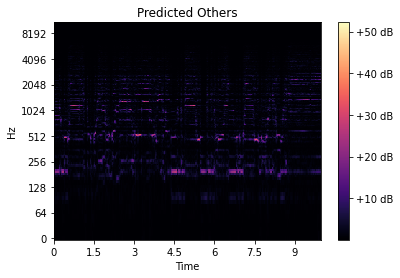

In [104]:
fig, ax = plt.subplots()
img = librosa.display.specshow(np.abs(stft_op), x_axis='time', y_axis='log', ax=ax)
ax.set(title='Predicted Others')
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.savefig(out+'Predicted_Others.png')
plt.show()

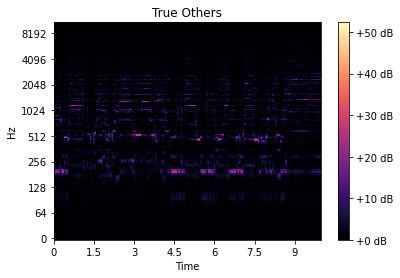

In [105]:
fig, ax = plt.subplots()
img = librosa.display.specshow(np.abs(stft_o), x_axis='time', y_axis='log', ax=ax)
ax.set(title='True Others')
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.savefig(out+'True_Others.png')
plt.show()

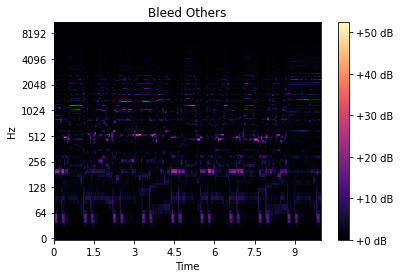

In [106]:
fig, ax = plt.subplots()
img = librosa.display.specshow(np.abs(stft_ob), x_axis='time', y_axis='log', ax=ax)
ax.set(title='Bleed Others')
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.savefig(out+'Bleed_Others.png')
plt.show()